# SET ENVIRONMENT

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
from sklearn import preprocessing
import pandas as pd
import scipy.signal
import pickle
import csv
import random

import tensorflow as tf
import tensorflow.keras as tfk
from keras.models import Sequential


In [ ]:
# Random seed for reproducibility
seed = 27

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/AI_in_Medicine_Project/

Mounted at /content/drive
/content/drive/My Drive/AI_in_Medicine_Project


# CALLBACKS

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime


def create_folders_and_callbacks(model_name):
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]

    # Model checkpoint
    # ----------------
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ckpt_dir, 'cp'),
        save_weights_only=False,
        save_best_only=False)
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    # ---------------------------------
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                                 profile_batch=0,
                                                 histogram_freq=1)
    callbacks.append(tb_callback)

    return callbacks

# MODELS

* LSTM
* Bi-directional LSTM
* 1D CNN

In [ ]:
def build_lstm_model(input_shape):

    model = Sequential()
    model.add(tfk.layers.LSTM(64, return_sequences=False, input_shape=input_shape))
    model.add(tfk.layers.Dense(32, name='dense_1'))
    model.add(tfk.layers.Dense(3, activation='softmax', name='output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tfk.losses.CategoricalCrossentropy(),
                metrics=[tfk.metrics.CategoricalAccuracy()])

    return model

def build_bi_lstm_model(input_shape):

    model = Sequential()
    model.add(tfk.layers.Bidirectional(tfk.layers.LSTM(64, return_sequences=False, input_shape=input_shape)))
    model.add(tfk.layers.Dense(32, name='dense_1'))
    model.add(tfk.layers.Dense(3, activation='softmax', name='output'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tfk.losses.CategoricalCrossentropy(),
                metrics=[tfk.metrics.CategoricalAccuracy()])

    return model

def build_1d_cnn_model(input_shape):

    model = Sequential()
    model.add(tfk.layers.Conv1D(filters = 64, kernel_size = 5, input_shape=input_shape))
    model.add(tfk.layers.Dropout(0.3))
    model.add(tfk.layers.Flatten())
    #model.add(tfk.layers.Dense(32, name='dense_1'))
    model.add(tfk.layers.Dense(3, activation='softmax', name='output'))


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tfk.losses.CategoricalCrossentropy(),
                metrics=[tfk.metrics.CategoricalAccuracy()])

    return model

# DATA LOADING

In [ ]:
dataset = pd.read_csv('dataset_with_more_features.csv', index_col=None)
dataset = dataset.iloc[:, 1:]
dataset.head(5)

,lead_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,mean_RR,mean_Peaks,median_RR,median_Peaks,std_RR,std_Peaks,log_curr_RR,log_next_RR,0.1
0,0,-0.283299,-0.263600,-0.287308,-0.320252,-0.308638,-0.267492,-0.239162,-0.213246,-0.174633,-0.174628,-0.258918,-0.376202,-0.445668,-0.470676,-0.505284,-0.551621,-0.575885,-0.586329,-0.611759,-0.637165,-0.633619,-0.625611,-0.653099,-0.652546,-0.440570,0.087500,0.716012,1.000000,0.706180,0.047966,-0.567509,-0.886688,-0.931206,-0.893990,-0.903365,-0.927710,-0.925005,-0.928219,-0.954931,-0.978122,-0.988625,-0.994276,-0.988838,-0.974828,-0.973372,-0.988058,-1.000000,-0.999176,-0.988819,-0.970214,-0.942617,-0.908062,-0.870304,-0.830713,-0.785741,-0.739185,-0.711519,-0.715006,-0.734607,-0.756479,-0.786041,-0.819814,-0.838976,-0.841898,-0.846225,-0.859363,-0.874458,-0.885567,-0.889713,-0.886801,80.810175,0.019209,81.0,0.0,5.414351,0.369582,4.394449,4.394449,N
1,0,-0.652404,-0.641507,-0.619037,-0.613962,-0.631233,-0.643332,-0.641352,-0.648237,-0.668237,-0.666577,-0.623620,-0.573367,-0.546704,-0.518793,-0.475080,-0.470636,-0.544778,-0.640111,-0.689017,-0.717090,-0.770664,-0.812496,-0.797160,-0.771559,-0.787937,-0.803995,-0.779532,-0.775940,-0.825585,-0.776977,-0.422255,0.220665,0.825983,1.000000,0.623988,-0.058777,-0.671221,-0.974769,-0.999288,-0.952152,-0.962756,-0.988189,-0.976976,-0.960688,-0.966331,-0.977528,-0.985853,-0.996283,-1.000000,-0.989083,-0.973181,-0.961793,-0.954681,-0.950664,-0.943615,-0.918947,-0.871757,-0.814343,-0.756348,-0.695572,-0.631718,-0.574366,-0.535972,-0.521499,-0.525274,-0.537298,-0.550773,-0.566408,-0.587956,-0.607787,80.810175,0.019209,81.0,0.0,5.414351,0.369582,4.394449,4.394449,N
2,0,-0.736180,-0.730167,-0.704406,-0.689202,-0.695008,-0.706108,-0.712779,-0.725130,-0.742473,-0.732065,-0.677413,-0.616812,-0.579917,-0.543462,-0.505416,-0.519954,-0.604608,-0.691138,-0.722995,-0.741526,-0.803950,-0.869336,-0.869454,-0.833796,-0.822811,-0.814419,-0.786057,-0.804702,-0.874063,-0.792952,-0.354952,0.343893,0.915280,1.000000,0.553581,-0.151616,-0.743585,-1.000000,-0.984966,-0.924579,-0.933193,-0.964819,-0.978333,-0.984378,-0.982639,-0.970667,-0.966970,-0.978133,-0.988314,-0.990384,-0.990958,-0.988573,-0.975118,-0.955494,-0.943909,-0.938399,-0.916503,-0.864303,-0.794060,-0.722680,-0.654250,-0.599362,-0.579870,-0.590625,-0.595612,-0.584612,-0.586253,-0.611730,-0.638351,-0.651917,80.810175,0.019209,81.0,0.0,5.414351,0.369582,4.394449,4.394449,N
3,0,-0.603599,-0.609930,-0.599367,-0.588966,-0.591858,-0.595776,-0.597399,-0.617393,-0.649250,-0.640029,-0.572423,-0.506843,-0.478307,-0.446181,-0.412073,-0.449041,-0.553808,-0.626988,-0.640675,-0.669162,-0.734120,-0.770712,-0.756978,-0.744226,-0.752962,-0.746035,-0.722150,-0.740174,-0.775039,-0.619917,-0.099520,0.599877,1.000000,0.804129,0.162656,-0.526048,-0.933745,-1.000000,-0.924205,-0.902931,-0.934899,-0.949114,-0.946460,-0.944869,-0.938798,-0.934744,-0.940931,-0.947718,-0.954278,-0.972323,-0.992237,-0.987113,-0.956924,-0.933350,-0.933414,-0.938852,-0.924832,-0.881245,-0.810983,-0.730434,-0.662369,-0.618449,-0.595928,-0.586014,-0.581862,-0.586182,-0.603949,-0.625171,-0.635675,-0.640861,80.810175,0.019209,81.0,0.0,5.414351,0.369582,4.394449,4.394449,N
4,0,-0.602973,-0.608122,-0.596711,-0.584638,-0.583413,-0.577879,-0.565852,-0.580178,-0.615132,-0.602931,-0.529176,-0.464177,-0.431027,-0.389630,-0.366914,-0.429369,-0.537958,-0.596816,-0.613782,-0.663222,-0.735558,-0.766968,-0.766344,-0.780174,-0.790858,-0.762587,-0.733590,-0.765359,-0.797794,-0.617282,-0.074603,0.625537,1.000000,0.758961,0.083479,-0.595796,-0.962143,-1.000000,-0.926098,-0.915369,-0.950663,-0.962138,-0.952837,-0.949670,-0.954469,-0.959327,-0.959453,-0.956374,-0.957612,-0.966753,-0.975136,-0.968556,-0.947391,-0.930263,-0.924864,-0.912576,-0.876316,-0.819195,-0.746717,-0.665515,-0.603364,-0.586195,-0.597624,-0.604473,

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Get beats and labels
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

NORMAL = "N"
VENTRICULAR = "V"
SUPER_VENTRICULAR = "S"

# Under and oversampling to balance the unbalanced dataset
under = RandomUnderSampler(sampling_strategy={NORMAL: 300000})
X_res, y_res = under.fit_resample(X_train, y_train)
smote = SMOTE(sampling_strategy={VENTRICULAR: 100000, SUPER_VENTRICULAR: 100000})
X_res, y_res = smote.fit_resample(X_res, y_res)

# One-hot encoding the labels
y_res = pd.get_dummies(y_res).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()

# Reshaping the
X_res = X_res.to_numpy()
X_res = X_res.reshape((X_res.shape[0], X_res.shape[1], 1))

X_test = X_test.to_numpy()
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# TRAINING & EVALUATION

In [17]:
input_shape = (79,1)

# Create callbacks folder and the model
callbacks = create_folders_and_callbacks(model_name='conv1d_feat')
model = build_1d_cnn_model(input_shape)

# Train the model
history = model.fit(
    x=X_res,
    y=y_res,
    batch_size=50,
    epochs=100,
    validation_split=.1,
    callbacks=callbacks
).history


Epoch 1/100
8995/9000 [============================>.] - ETA: 0s - loss: 0.8831 - categorical_accuracy: 0.6485INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 73s 8ms/step - loss: 0.8830 - categorical_accuracy: 0.6486 - val_loss: 2.2752 - val_categorical_accuracy: 0.2420 - lr: 0.0010
Epoch 2/100
8996/9000 [============================>.] - ETA: 0s - loss: 0.8204 - categorical_accuracy: 0.6601INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 68s 8ms/step - loss: 0.8203 - categorical_accuracy: 0.6601 - val_loss: 1.9839 - val_categorical_accuracy: 0.2073 - lr: 0.0010
Epoch 3/100
8999/9000 [============================>.] - ETA: 0s - loss: 0.8082 - categorical_accuracy: 0.6638INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 69s 8ms/step - loss: 0.8082 - categorical_accuracy: 0.6638 - val_loss: 2.4038 - val_categorical_accuracy: 0.0730 - lr: 0.0010
Epoch 4/100
8996/9000 [============================>.] - ETA: 0s - loss: 0.8168 - categorical_accuracy: 0.6611INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 70s 8ms/step - loss: 0.8169 - categorical_accuracy: 0.6611 - val_loss: 1.7942 - val_categorical_accuracy: 0.1775 - lr: 0.0010
Epoch 5/100
8999/9000 [============================>.] - ETA: 0s - loss: 0.8117 - categorical_accuracy: 0.6628INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 68s 8ms/step - loss: 0.8117 - categorical_accuracy: 0.6628 - val_loss: 1.8648 - val_categorical_accuracy: 0.2243 - lr: 0.0010
Epoch 6/100
8997/9000 [============================>.] - ETA: 0s - loss: 0.8139 - categorical_accuracy: 0.6611INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 66s 7ms/step - loss: 0.8139 - categorical_accuracy: 0.6611 - val_loss: 1.7834 - val_categorical_accuracy: 0.2555 - lr: 0.0010
Epoch 7/100
8999/9000 [============================>.] - ETA: 0s - loss: 0.8173 - categorical_accuracy: 0.6614INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 70s 8ms/step - loss: 0.8173 - categorical_accuracy: 0.6614 - val_loss: 1.5730 - val_categorical_accuracy: 0.3869 - lr: 0.0010
Epoch 8/100
9000/9000 [==============================] - ETA: 0s - loss: 0.8138 - categorical_accuracy: 0.6614INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 68s 8ms/step - loss: 0.8138 - categorical_accuracy: 0.6614 - val_loss: 1.8165 - val_categorical_accuracy: 0.1852 - lr: 0.0010
Epoch 9/100
8999/9000 [============================>.] - ETA: 0s - loss: 0.8096 - categorical_accuracy: 0.6625INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 70s 8ms/step - loss: 0.8096 - categorical_accuracy: 0.6625 - val_loss: 1.6567 - val_categorical_accuracy: 0.2688 - lr: 0.0010
Epoch 10/100
8999/9000 [============================>.] - ETA: 0s - loss: 0.8126 - categorical_accuracy: 0.6620INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 70s 8ms/step - loss: 0.8126 - categorical_accuracy: 0.6620 - val_loss: 1.6756 - val_categorical_accuracy: 0.3188 - lr: 0.0010
Epoch 11/100
8995/9000 [============================>.] - ETA: 0s - loss: 0.8094 - categorical_accuracy: 0.6636INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 81s 9ms/step - loss: 0.8094 - categorical_accuracy: 0.6636 - val_loss: 1.8537 - val_categorical_accuracy: 0.1854 - lr: 0.0010
Epoch 12/100
8999/9000 [============================>.] - ETA: 0s - loss: 0.8108 - categorical_accuracy: 0.6626INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 78s 9ms/step - loss: 0.8108 - categorical_accuracy: 0.6626 - val_loss: 2.2459 - val_categorical_accuracy: 0.2078 - lr: 0.0010
Epoch 13/100
8999/9000 [============================>.] - ETA: 0s - loss: 0.7682 - categorical_accuracy: 0.6755INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 77s 9ms/step - loss: 0.7682 - categorical_accuracy: 0.6755 - val_loss: 1.4707 - val_categorical_accuracy: 0.3299 - lr: 5.0000e-04
Epoch 14/100
8998/9000 [============================>.] - ETA: 0s - loss: 0.7667 - categorical_accuracy: 0.6760INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 68s 8ms/step - loss: 0.7667 - categorical_accuracy: 0.6760 - val_loss: 1.5713 - val_categorical_accuracy: 0.2333 - lr: 5.0000e-04
Epoch 15/100
8999/9000 [============================>.] - ETA: 0s - loss: 0.7631 - categorical_accuracy: 0.6768INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 66s 7ms/step - loss: 0.7631 - categorical_accuracy: 0.6768 - val_loss: 1.6132 - val_categorical_accuracy: 0.4417 - lr: 5.0000e-04
Epoch 16/100
8995/9000 [============================>.] - ETA: 0s - loss: 0.7635 - categorical_accuracy: 0.6771INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 66s 7ms/step - loss: 0.7635 - categorical_accuracy: 0.6771 - val_loss: 1.6378 - val_categorical_accuracy: 0.2555 - lr: 5.0000e-04
Epoch 17/100
8999/9000 [============================>.] - ETA: 0s - loss: 0.7642 - categorical_accuracy: 0.6770INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 66s 7ms/step - loss: 0.7642 - categorical_accuracy: 0.6770 - val_loss: 1.6941 - val_categorical_accuracy: 0.2906 - lr: 5.0000e-04
Epoch 18/100
8994/9000 [============================>.] - ETA: 0s - loss: 0.7647 - categorical_accuracy: 0.6762INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 63s 7ms/step - loss: 0.7647 - categorical_accuracy: 0.6762 - val_loss: 1.6970 - val_categorical_accuracy: 0.2146 - lr: 5.0000e-04
Epoch 19/100
8997/9000 [============================>.] - ETA: 0s - loss: 0.7493 - categorical_accuracy: 0.6806INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 64s 7ms/step - loss: 0.7493 - categorical_accuracy: 0.6806 - val_loss: 1.5644 - val_categorical_accuracy: 0.3070 - lr: 2.5000e-04
Epoch 20/100
8994/9000 [============================>.] - ETA: 0s - loss: 0.7491 - categorical_accuracy: 0.6811INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 63s 7ms/step - loss: 0.7491 - categorical_accuracy: 0.6811 - val_loss: 1.7216 - val_categorical_accuracy: 0.1948 - lr: 2.5000e-04
Epoch 21/100
8996/9000 [============================>.] - ETA: 0s - loss: 0.7472 - categorical_accuracy: 0.6820INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 64s 7ms/step - loss: 0.7472 - categorical_accuracy: 0.6820 - val_loss: 1.7320 - val_categorical_accuracy: 0.3068 - lr: 2.5000e-04
Epoch 22/100
8997/9000 [============================>.] - ETA: 0s - loss: 0.7384 - categorical_accuracy: 0.6873INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 65s 7ms/step - loss: 0.7384 - categorical_accuracy: 0.6873 - val_loss: 1.4983 - val_categorical_accuracy: 0.3653 - lr: 2.5000e-04
Epoch 23/100
8999/9000 [============================>.] - ETA: 0s - loss: 0.7206 - categorical_accuracy: 0.6981INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


INFO:tensorflow:Assets written to: experiments/conv1d_feat_Feb08_22-20-19/ckpts/cp/assets


9000/9000 [==============================] - 67s 7ms/step - loss: 0.7205 - categorical_accuracy: 0.6981 - val_loss: 1.6755 - val_categorical_accuracy: 0.2967 - lr: 2.5000e-04


In [14]:
# Save the model
model.save('1dconv_more_feat_smote_change_1')

# Predict with this model
predictions = model.predict(X_test)
predictions

INFO:tensorflow:Assets written to: bi_lstm_64_more_feat_smote_change_1/assets


INFO:tensorflow:Assets written to: bi_lstm_64_more_feat_smote_change_1/assets


array([[1.0000000e+00, 1.4595272e-08, 6.0584822e-13],
       [1.0000000e+00, 3.5690961e-11, 1.0868992e-10],
       [9.9999988e-01, 2.5458025e-08, 8.9709218e-08],
       ...,
       [1.0000000e+00, 6.6049193e-09, 1.2511897e-14],
       [9.9999988e-01, 8.2949271e-08, 3.4161762e-10],
       [9.9999905e-01, 2.4956718e-14, 9.7937107e-07]], dtype=float32)

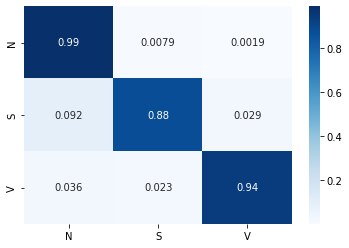

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(y_test.argmax(axis=1), 
                          predictions.argmax(axis=1), normalize='true')

# Plot the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(matrix, annot=True, cmap='Blues')
ax.set_xticklabels(['N', 'S', 'V'])
ax.set_yticklabels(['N', 'S', 'V'])

fig.savefig('1dconv_more_feat_smote_change.png')

In [16]:
from sklearn.metrics import classification_report

target_names = ['N', 'S', 'V']
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

           N       0.99      0.99      0.99     90702
           S       0.81      0.88      0.84      3878
           V       0.91      0.94      0.93      3155

    accuracy                           0.98     97735
   macro avg       0.91      0.94      0.92     97735
weighted avg       0.98      0.98      0.98     97735

